In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
import os

In [2]:
#import all needed modules
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Input,Dense,Conv2D,ReLU,ELU,\
  Activation,Flatten,AveragePooling2D,Softmax,BatchNormalization,MaxPooling2D,\
  Dropout, Reshape, LSTM
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,\
  ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
from datetime import datetime
from sklearn.model_selection import train_test_split
import os

In [3]:
def crop_data_sequentially(X, y, person, sample_len, stride):
    total_X_crops = []
    total_y_crops = []
    total_person_crops = []

    # Calculate the number of crops
    num_crops = (X.shape[2] - sample_len) // stride + 1

    for i in range(num_crops):
        start = i * stride
        end = start + sample_len
        total_X_crops.append(X[:, :, start:end])
        total_y_crops.append(y)
        total_person_crops.append(person)

    # Stack all crops
    cropped_X = np.vstack(total_X_crops)
    cropped_y = np.hstack(total_y_crops)
    cropped_person = np.hstack(total_person_crops)

    return cropped_X, cropped_y, cropped_person


def train_data_prep(X,y,sub_sample,average,noise):

    total_X = None
    total_y = None

    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)


    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)

    # Averaging + noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)

    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)

    # Subsampling

    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)

        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))


    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X):

    total_X = None


    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)


    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)

    return total_X

In [4]:
# Load your data here

X_train_valid = np.load("/Users/rakesh/Desktop/project/X_train_valid.npy")
y_train_valid = np.load("/Users/rakesh/Desktop/project/y_train_valid.npy")
person_train_valid = np.load("/Users/rakesh/Desktop/project/person_train_valid.npy")
X_test = np.load("/Users/rakesh/Desktop/project/X_test.npy")
y_test = np.load("/Users/rakesh/Desktop/project/y_test.npy")
person_test = np.load("/Users/rakesh/Desktop/project/person_test.npy")

y_train_valid -= 769
y_test -= 769

num_test_samples = X_test.shape[0]
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


Shape of X after trimming: (2115, 22, 800)
Shape of X after maxpooling: (2115, 22, 400)
Shape of X after averaging+noise and concatenating: (4230, 22, 400)
Shape of X after subsampling and concatenating: (8460, 22, 400)
Shape of Y: (8460,)
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of preprocessed training/validation data: (8460, 22, 400)
Shape of preprocessed test data: (443, 22, 400)
Shape of test labels after categorical conversion: (443,)


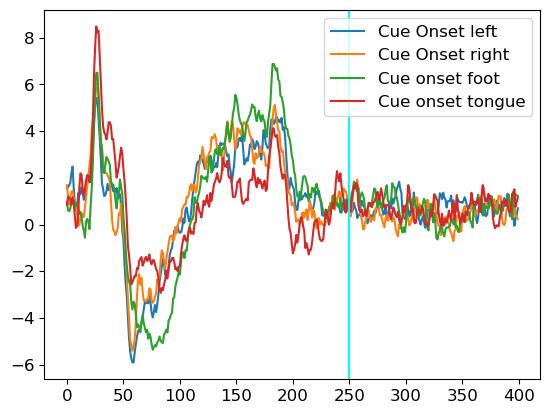

In [5]:
# Preprocess the raw training/validation and test datasets
X_train_valid_prep, y_train_valid_prep = train_data_prep(X_train_valid, y_train_valid, 2, 2, True)
X_test_prep = test_data_prep(X_test)

print("Shape of preprocessed training/validation data:", X_train_valid_prep.shape)
print("Shape of preprocessed test data:", X_test_prep.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

## Visualizing the data

ch_data = X_train_valid_prep[:,3,:]


class_0_ind = np.where(y_train_valid_prep == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid_prep == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid_prep == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid_prep == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(400),avg_ch_data_class_0)
plt.plot(np.arange(400),avg_ch_data_class_1)
plt.plot(np.arange(400),avg_ch_data_class_2)
plt.plot(np.arange(400),avg_ch_data_class_3)
plt.axvline(x=250, label='line at t=250',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])


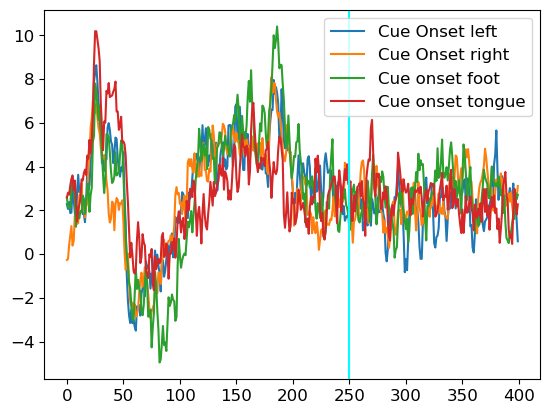

In [6]:
## Visualizing the data

ch_data = X_test_prep[:,3,:]


class_0_ind = np.where(y_test== 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_test == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_test == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_test == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(400),avg_ch_data_class_0)
plt.plot(np.arange(400),avg_ch_data_class_1)
plt.plot(np.arange(400),avg_ch_data_class_2)
plt.plot(np.arange(400),avg_ch_data_class_3)
plt.axvline(x=250, label='line at t=250',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

Training/Valid Cropped data shape: (42300, 22, 200)
Training/Valid Cropped target shape: (42300,)
Training/Valid Cropped person shape: (2115, 5)
Test Cropped data shape: (2215, 22, 200)
Test Cropped target shape: (2215,)
Test Cropped person shape: (443, 5)


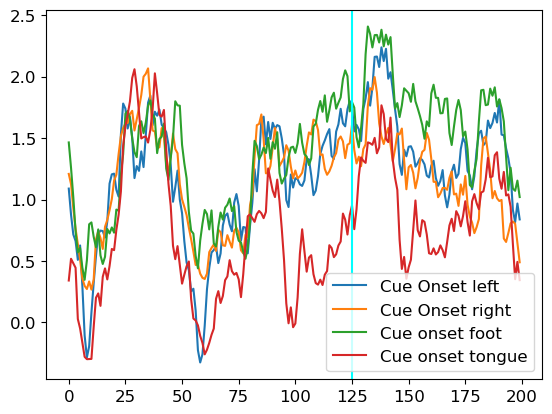

In [7]:
sample_len = 200 
stride = 50 

X_train_valid_crop, y_train_valid_crop,person_train_valid_crop = crop_data_sequentially(
    X_train_valid_prep, y_train_valid_prep, person_train_valid, sample_len=sample_len, stride=stride
)

X_test_crop, y_test_crop, person_test_crop = crop_data_sequentially(
    X_test_prep, y_test, person_test, sample_len=sample_len, stride=stride
)

print('Training/Valid Cropped data shape: {}'.format(X_train_valid_crop.shape))
print('Training/Valid Cropped target shape: {}'.format(y_train_valid_crop.shape))
print('Training/Valid Cropped person shape: {}'.format(person_train_valid_crop.shape))
print('Test Cropped data shape: {}'.format(X_test_crop.shape))
print('Test Cropped target shape: {}'.format(y_test_crop.shape))
print('Test Cropped person shape: {}'.format(person_test_crop.shape))


ch_data = X_train_valid_crop[:,3,:]


class_0_ind = np.where(y_train_valid_crop == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid_crop == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid_crop == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid_crop == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(200),avg_ch_data_class_0)
plt.plot(np.arange(200),avg_ch_data_class_1)
plt.plot(np.arange(200),avg_ch_data_class_2)
plt.plot(np.arange(200),avg_ch_data_class_3)
plt.axvline(x=125, label='line at t=250',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])


In [8]:
X = X_train_valid_crop
y = y_train_valid_crop 

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
X_test = X_test_crop.reshape(X_test_crop.shape[0], X_test_crop.shape[1], X_test_crop.shape[2], 1)

# One-hot encode the labels
# Assuming that the labels are already integers starting from 0 to num_classes-1
num_classes = np.max(y_train) + 1  # This finds the max label index and adds 1 to get the number of classes
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test_crop, num_classes)

print ('Training/Valid data shape: {}'.format(X_train.shape))
print ('Validation data shape: {}'.format(X_val.shape))
print ('Y Training target shape: {}'.format(y_train.shape))
print ('Y val shape: {}'.format(y_val.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('y test shape: {}'.format(y_test.shape))


Training/Valid data shape: (33840, 22, 200, 1)
Validation data shape: (8460, 22, 200, 1)
Y Training target shape: (33840, 4)
Y val shape: (8460, 4)
Test data shape: (2215, 22, 200, 1)
y test shape: (2215, 4)


In [9]:
# Building the CNN model using sequential class
hybrid_cnn_lstm_model = Sequential()

# Conv. block 1
hybrid_cnn_lstm_model.add(Conv2D(filters=25, kernel_size=(5,5), padding='same', activation='elu', input_shape=(22,200,1)))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 2
hybrid_cnn_lstm_model.add(Conv2D(filters=50, kernel_size=(5,5), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 3
hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(5,5), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 4
hybrid_cnn_lstm_model.add(Conv2D(filters=200, kernel_size=(5,5), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

hybrid_cnn_lstm_model.add(Flatten())

# Output layer with Softmax activation
hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

# Printing the model summary
hybrid_cnn_lstm_model.summary()

2024-03-15 20:20:43.412678: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-03-15 20:20:43.412709: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-03-15 20:20:43.412719: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-03-15 20:20:43.412755: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-15 20:20:43.412768: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 22, 200, 25)       650       
                                                                 
 max_pooling2d (MaxPooling2  (None, 8, 200, 25)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 8, 200, 25)        100       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 8, 200, 25)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 200, 50)        31300     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 3, 200, 50)        0

In [10]:
# Model parameters
learning_rate = 1e-3
epochs = 50
hybrid_cnn_lstm_optimizer = tf.keras.optimizers.legacy.Adam(lr=learning_rate)

/Users/rakesh/tensorflow-test/env/lib/python3.8/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
# Compile the model with the correct loss function for multi-class classification
hybrid_cnn_lstm_model.compile(
    loss='categorical_crossentropy',
    optimizer=hybrid_cnn_lstm_optimizer,
    metrics=['accuracy']
)

# Fit the model
hybrid_cnn_lstm_model.fit(
    X_train,  # Make sure this is reshaped to the correct dimensions
    y_train,  # Make sure this is one-hot encoded
    batch_size=64,
    epochs=epochs,
    validation_data=(X_val, y_val),  # Make sure validation data is also correctly processed
    verbose=True
)

Epoch 1/50


2024-03-15 20:20:47.142037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


529/529 [==============================] - ETA: 0s - loss: 5.0449 - accuracy: 0.2714

2024-03-15 20:22:26.757724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


529/529 [==============================] - 108s 191ms/step - loss: 5.0449 - accuracy: 0.2714 - val_loss: 3.0569 - val_accuracy: 0.2994
Epoch 2/50
529/529 [==============================] - 98s 185ms/step - loss: 3.4132 - accuracy: 0.2852 - val_loss: 1.6337 - val_accuracy: 0.3228
Epoch 3/50
529/529 [==============================] - 101s 191ms/step - loss: 2.0371 - accuracy: 0.3065 - val_loss: 1.3957 - val_accuracy: 0.3557
Epoch 4/50
529/529 [==============================] - 102s 192ms/step - loss: 1.4427 - accuracy: 0.3515 - val_loss: 1.2834 - val_accuracy: 0.3939
Epoch 5/50
529/529 [==============================] - 100s 190ms/step - loss: 1.3028 - accuracy: 0.3918 - val_loss: 1.2876 - val_accuracy: 0.3879
Epoch 6/50
529/529 [==============================] - 98s 185ms/step - loss: 1.2542 - accuracy: 0.4199 - val_loss: 1.2191 - val_accuracy: 0.4488
Epoch 7/50
529/529 [==============================] - 98s 185ms/step - loss: 1.2212 - accuracy: 0.4485 - val_loss: 1.2129 - val_accuracy:

In [12]:
hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])

Test accuracy of the hybrid CNN-LSTM model: 0.46004512906074524
